In [35]:
import os
import shutil
import pandas as pd
from collections import defaultdict
from pysentimiento import create_analyzer  # Assuming you're using pysentimiento
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import re

In [36]:


def get_sentiment_score(sentiment_result):
    """
    Determine sentiment label and score based on sentiment probabilities.
    """
    sentiment_score = sentiment_result.probas['POS']*1 + sentiment_result.probas['NEG']*(-1)
    sentiment = "NEU"
    if sentiment_score > 0.2:
        sentiment = "POS"
    elif sentiment_score < -0.2:
        sentiment = "NEG"
    return sentiment, sentiment_score

def sentiment_analysis(source_path='tukaani-project_xz/'):
    """
    Perform both message and post-level sentiment analysis. 
    Returns a DataFrame (post_sentiment_results) and a DataFrame (user_interactions)
    containing columns: date, file_name, from, target, sentiment, sentiment_score.
    """

    # Paths for issues+PR and mailing list
    folder_path = os.path.join(source_path, "individual_issue_PR/")
    ml_path = os.path.join("mailing_list/", "individual_ml_convo")

    # Create the sentiment analyzer
    analyzer = create_analyzer(task="sentiment", lang="en")

    user_interactions_list = []  # We'll build a row for each message

    count = 0
    print("Running sentiment analysis...")

    # 1. Process each file in the Issues+PR folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            sentiment_score_total = 0
            num_messages = 0

            for index, row in df.iterrows():
                source_author = row.get('from', 'Unknown')
                target_authors = row.get('to', [])
                if not isinstance(target_authors, list):

                    target_authors = [target_authors]

                text = str(row.get('body', ''))
                date = row.get('created_at', '')
                result = analyzer.predict(text)
                sentiment, sentiment_score = get_sentiment_score(result)

                sentiment_score_total += sentiment_score
                num_messages += 1

                # Add a row for each target in user_interactions_list
                for target in target_authors:
                    user_interactions_list.append({
                        "date": date,
                        "file_name": filename,
                        "from": source_author,
                        "target": target,
                        "sentiment": sentiment,
                        "sentiment_score": sentiment_score
                    })
            count += 1

    print(f"Done with {count} issue and PR sentiment analysis")
    print("Now moving to ML conversation sentiment analysis...")

    # 2. Process each file in the mailing list folder
    for filename in os.listdir(ml_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(ml_path, filename)
            df = pd.read_csv(file_path)
            sentiment_score_total = 0
            num_messages = 0

            for index, row in df.iterrows():
                source_author = row.get('from', 'Unknown')
                target_authors = row.get('to', [])
                if not isinstance(target_authors, list):
                    target_authors = [target_authors]

                text = str(row.get('body', ''))
                date = row.get('timestamp', '')
                result = analyzer.predict(text)
                sentiment, sentiment_score = get_sentiment_score(result)

                sentiment_score_total += sentiment_score
                num_messages += 1

                # Add a row for each target in user_interactions_list
                for target in target_authors:
                    user_interactions_list.append({
                        "date": date,
                        "file_name": filename,
                        "from": source_author,
                        "target": target,
                        "sentiment": sentiment,
                        "sentiment_score": sentiment_score
                    })


            count += 1

    print(f"Thread-level sentiment analysis done on {count} posts.")
    print("----------------------------------------------")



    # Convert user_interactions_list to DataFrame with desired columns
    user_interactions = pd.DataFrame(user_interactions_list, columns=[
        "date", "file_name", "from", "target", "sentiment", "sentiment_score"
    ])

    print("Now each user interaction is on its own row with date, file_name, from, target, sentiment, sentiment_score.")

    return user_interactions


In [37]:
user_interactions = sentiment_analysis()


Running sentiment analysis...
Done with 68 issue and PR sentiment analysis
Now moving to ML conversation sentiment analysis...
Thread-level sentiment analysis done on 100 posts.
----------------------------------------------
Now each user interaction is on its own row with date, file_name, from, target, sentiment, sentiment_score.


In [38]:
user_interactions 

,date,file_name,from,target,sentiment,sentiment_score
0,2024-03-30T00:23:17Z,issue_102.csv,nullyfae,['nullyfae'],NEU,-0.110173
1,2024-03-30T00:25:41Z,issue_102.csv,AffSeda,['nullyfae'],NEG,-0.803194
2,2024-03-30T00:26:39Z,issue_102.csv,Theldus,['AffSeda'],NEG,-0.733481
3,2024-03-30T00:46:52Z,issue_102.csv,nullyfae,AffSeda,POS,0.516297
4,2024-04-09T21:26:34Z,issue_102.csv,doclic,['nullyfae'],NEG,-0.850267
...,...,...,...,...,...,...
707,"Thu, 18 Jul 2024 07:14:00 -0700",conversation_665.csv,Lasse Collin,Lasse Collin,NEG,-0.298156
708,"Thu, 18 Jul 2024 08:04:06 -0700",conversation_665.csv,Brett Okken,Lasse Collin,NEU,0.026986
709,"Thu, 18 Jul 2024 09:16:16 -0700",conversation_665.csv,Lasse Collin,Lasse Collin,NEG,-0.597993
710,"Thu, 18 Jul 2024 09:41:23 -0700",conversation_665.csv,Brett Okken,Lasse Collin,POS,0.965322


In [39]:
import re

# A simplistic check for "Thu, 18 Jul 2024 09:16:16 -0700"
ml_pattern = re.compile(r"^[A-Z][a-z]{2}, \d{2} [A-Z][a-z]{2} \d{4} \d{2}:\d{2}:\d{2} [+-]\d{4}$")

def is_ml_format(date_str):
    """
    Returns True if date_str matches the ML format like:
    'Thu, 18 Jul 2024 09:16:16 -0700'
    Otherwise False.
    """
    if not isinstance(date_str, str):
        return False
    return bool(ml_pattern.match(date_str))

def reformat_ml_timestamp(date_str):
    """
    Parses a ML-format timestamp (e.g., 'Fri, 08 Jan 2021 10:36:26 -0800')
    and returns an ISO-8601 style string like '2021-01-08T18:36:26Z'.
    """
    # Parse with the known ML format
    dt = pd.to_datetime(date_str, format="%a, %d %b %Y %H:%M:%S %z", errors="raise")
    # Convert to UTC
    dt_utc = dt.tz_convert("UTC")
    # Return as ISO-8601 with 'Z' suffix
    return dt_utc.strftime("%Y-%m-%dT%H:%M:%SZ")

def reformat_issue_pr_timestamp(date_str):
    """
    If your Issue/PR timestamps look like '2024-03-29T23:25:37Z' or
    '2024-03-29 23:25:37', parse them, convert to UTC, reformat to ISO.
    """
    # Use flexible parser to handle normal formats
    dt = pd.to_datetime(date_str, errors="coerce", utc=True)
    # Return as ISO-8601 with 'Z' suffix
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ") if pd.notna(dt) else None

def unify_timestamp(date_str):
    # 1) Check if ML format
    if is_ml_format(date_str):
        try:
            return reformat_ml_timestamp(date_str)
        except ValueError:
            return None  # Couldn’t parse
    else:
        # 2) Attempt normal Issue/PR format
        return reformat_issue_pr_timestamp(date_str)


In [40]:
user_interactions["unified_date"] = user_interactions["date"].apply(unify_timestamp)
# Drop rows we couldn’t parse
user_interactions = user_interactions.dropna(subset=["unified_date"])

# Now parse them all as datetimes (if you want a datetime column)
user_interactions["date_parsed"] = pd.to_datetime(
    user_interactions["unified_date"], 
    errors="coerce", 
    utc=True
)

# Drop any leftover NaT
user_interactions.dropna(subset=["date_parsed"], inplace=True)

# Convert to naive if desired
user_interactions["date_parsed"] = user_interactions["date_parsed"].dt.tz_convert(None)

In [41]:
control_start_date = pd.to_datetime("2021-01-01")    # Start of control period
treatment_end_date = pd.to_datetime("2024-03-28")    # End of treatment period
cutoff_date = pd.to_datetime("2022-10-28")           # Jia Tan’s join date (cutoff)

analysis_df = user_interactions[
    (user_interactions["date_parsed"] >= control_start_date) &
    (user_interactions["date_parsed"] <= treatment_end_date)
].copy()

# Now you can safely do RDD or any other datetime operations on analysis_df



In [42]:
before_count = user_interactions[user_interactions["date_parsed"] < cutoff_date].shape[0]

# Count messages after cutoff
after_count = user_interactions[user_interactions["date_parsed"] >= cutoff_date].shape[0]

before_count

148

In [43]:
after_count 

564

In [44]:
analysis_df["months_since_JT_joined"] = (
    (analysis_df["date_parsed"] - cutoff_date) / pd.Timedelta(days=30)
).astype(int)

# For weekly analysis (7 days = 1 week)
analysis_df["weeks_since_JT_joined"] = (
    (analysis_df["date_parsed"] - cutoff_date) / pd.Timedelta(days=7)
).astype(int)

In [45]:
monthly_sentiment = (
    analysis_df.groupby("months_since_JT_joined")["sentiment_score"]
    .mean()
    .reset_index(name="avg_sentiment_score")
)
weekly_sentiment = (
    analysis_df.groupby("weeks_since_JT_joined")["sentiment_score"]
    .mean()
    .reset_index(name="avg_sentiment_score")
)

In [46]:
monthly_sentiment["treatment"] = (monthly_sentiment["months_since_JT_joined"] >= 0).astype(int)
weekly_sentiment["treatment"] = (weekly_sentiment["weeks_since_JT_joined"] >= 0).astype(int)

In [47]:
X_monthly = monthly_sentiment[["months_since_JT_joined", "treatment"]]
y_monthly = monthly_sentiment["avg_sentiment_score"]

lin_model_monthly = LinearRegression()
lin_model_monthly.fit(X_monthly, y_monthly)
monthly_sentiment["predicted"] = lin_model_monthly.predict(X_monthly)


X_weekly = weekly_sentiment[["weeks_since_JT_joined", "treatment"]]
y_weekly = weekly_sentiment["avg_sentiment_score"]

lin_model_weekly = LinearRegression()
lin_model_weekly.fit(X_weekly, y_weekly)
weekly_sentiment["predicted"] = lin_model_weekly.predict(X_weekly)

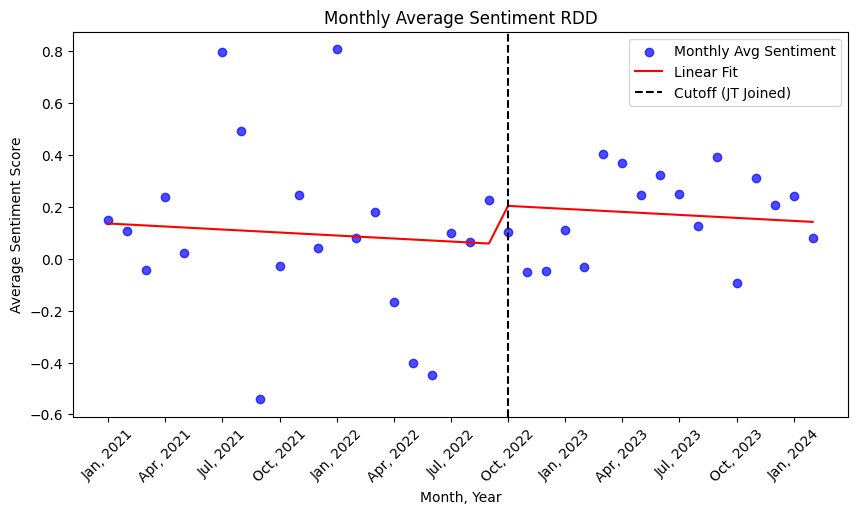

In [48]:
# Define a custom formatter for months
def month_year_formatter(x, pos):
    # x is the number of months offset from the cutoff date.
    # Round it to an integer and add it to the cutoff_date.
    m = int(round(x))
    dt = cutoff_date + pd.DateOffset(months=m)
    return dt.strftime("%b, %Y")  # e.g., "Jan, 2021"

plt.figure(figsize=(10, 5))
plt.scatter(
    monthly_sentiment["months_since_JT_joined"],
    monthly_sentiment["avg_sentiment_score"],
    color="blue", alpha=0.7, label="Monthly Avg Sentiment"
)
plt.plot(
    monthly_sentiment["months_since_JT_joined"],
    monthly_sentiment["predicted"],
    color="red", label="Linear Fit"
)
plt.axvline(x=0, color="black", linestyle="--", label="Cutoff (JT Joined)")
plt.xlabel("Month, Year")
plt.ylabel("Average Sentiment Score")
plt.title("Monthly Average Sentiment RDD")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Tick every 3 months
ax.xaxis.set_major_formatter(FuncFormatter(month_year_formatter))
plt.xticks(rotation=45)  # Rotate labels for readability
plt.legend()
plt.show()


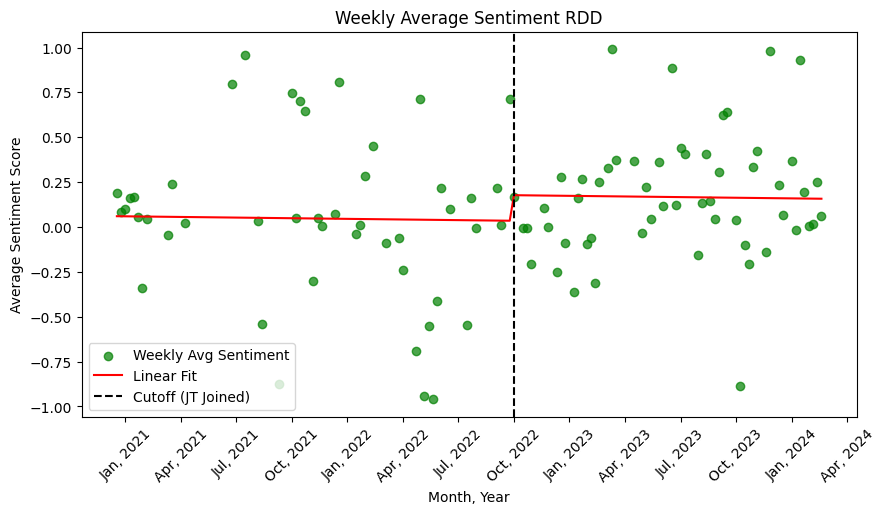

In [49]:
# Define a custom formatter for weeks
def week_to_month_year_formatter(x, pos):
    # x is the number of weeks offset from the cutoff date.
    # Round to integer weeks and convert to a date.
    dt = cutoff_date + pd.Timedelta(weeks=int(round(x)))
    return dt.strftime("%b, %Y")  # e.g., "Jan, 2021"

plt.figure(figsize=(10, 5))
plt.scatter(
    weekly_sentiment["weeks_since_JT_joined"],
    weekly_sentiment["avg_sentiment_score"],
    color="green", alpha=0.7, label="Weekly Avg Sentiment"
)
plt.plot(
    weekly_sentiment["weeks_since_JT_joined"],
    weekly_sentiment["predicted"],
    color="red", label="Linear Fit"
)
plt.axvline(x=0, color="black", linestyle="--", label="Cutoff (JT Joined)")
plt.xlabel("Month, Year")
plt.ylabel("Average Sentiment Score")
plt.title("Weekly Average Sentiment RDD")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(13))  # Approximately every 13 weeks (~3 months)
ax.xaxis.set_major_formatter(FuncFormatter(week_to_month_year_formatter))
plt.xticks(rotation=45)  # Rotate labels for readability
plt.legend()
plt.show()


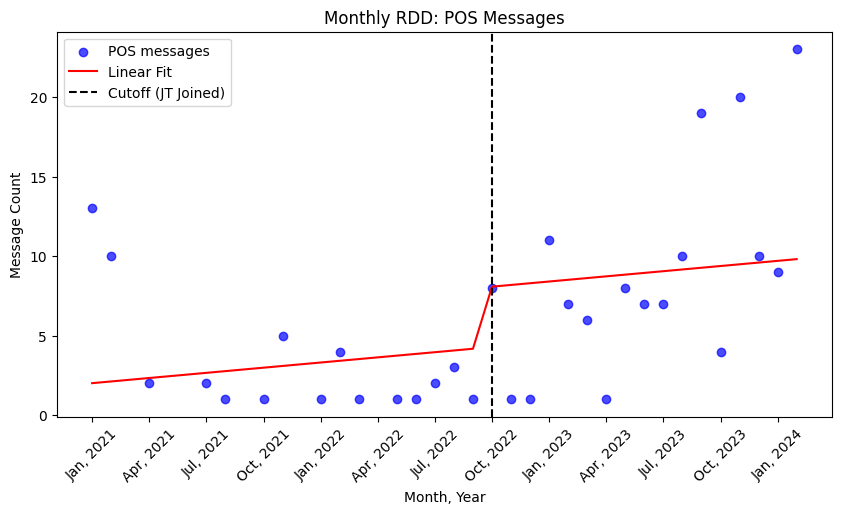

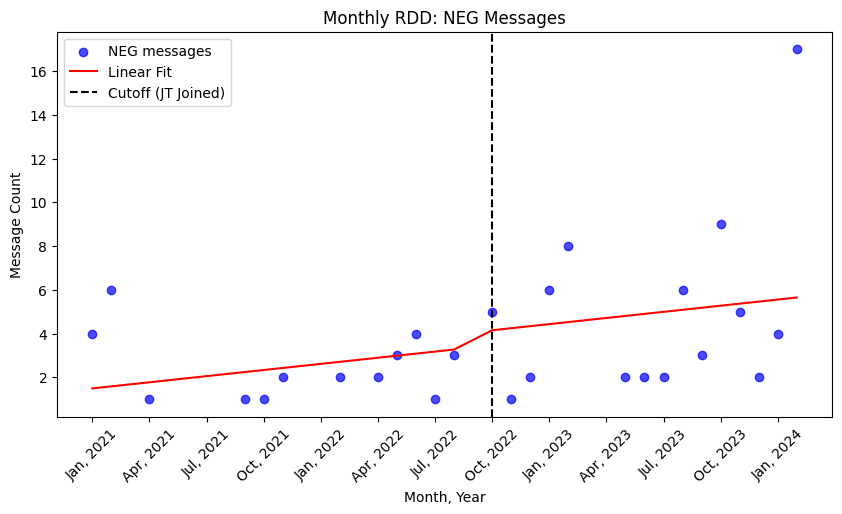

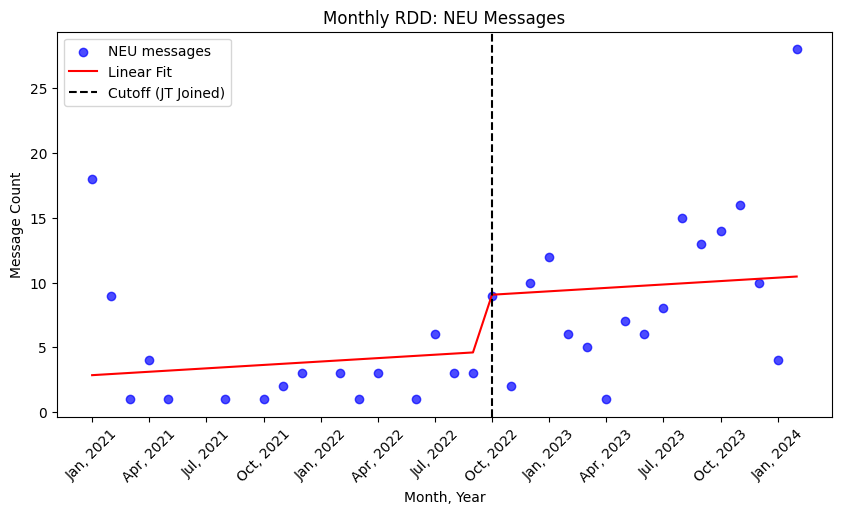

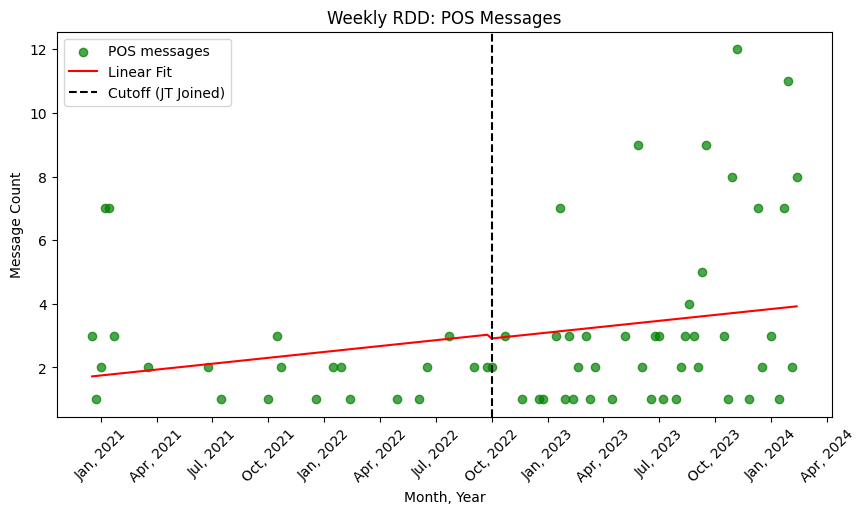

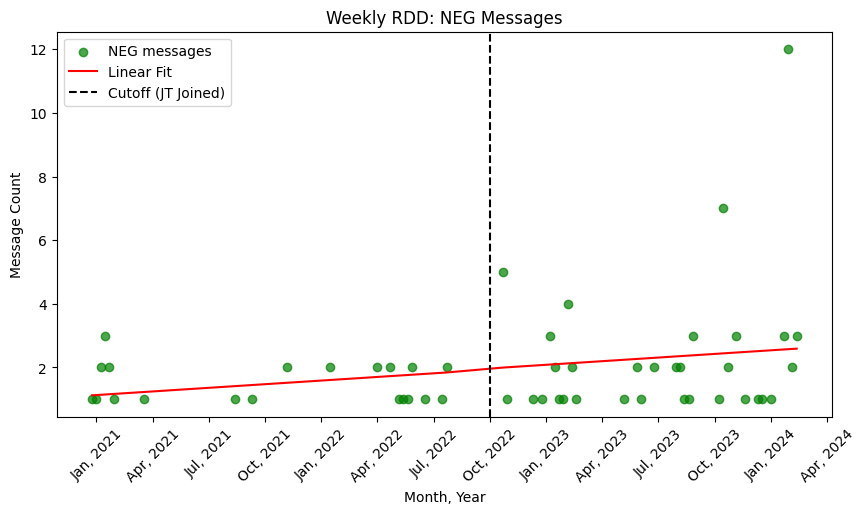

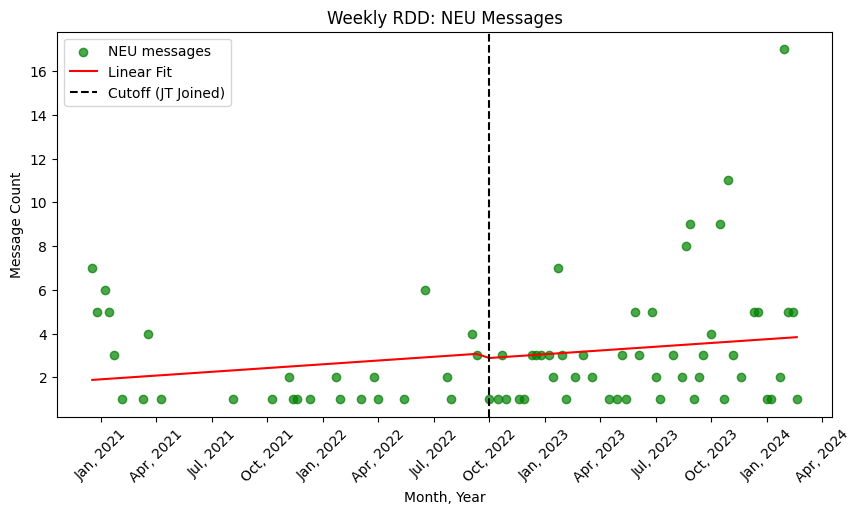

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

# ---------------------------
# 1. Define key dates
# ---------------------------
cutoff_date = pd.to_datetime("2022-10-28")      # Jia Tan's join date (cutoff)
treatment_end_date = pd.to_datetime("2024-03-28") # End of treatment period
control_start_date = pd.to_datetime("2021-01-01") # Start of control period

# ---------------------------
# 2. Filter DataFrame to Analysis Period
# ---------------------------
# Make sure the 'date_parsed' column is datetime; if not, parse it
user_interactions["date_parsed"] = pd.to_datetime(user_interactions["date_parsed"], errors="coerce")
analysis_df = user_interactions[
    (user_interactions["date_parsed"] >= control_start_date) &
    (user_interactions["date_parsed"] <= treatment_end_date)
].copy()

# ---------------------------
# 3. Create Forcing Variables
# ---------------------------
# Monthly forcing variable (approx. 30 days per month)
analysis_df["months_since_JT_joined"] = ((analysis_df["date_parsed"] - cutoff_date) / pd.Timedelta(days=30)).astype(int)
# Weekly forcing variable (7 days per week)
analysis_df["weeks_since_JT_joined"] = ((analysis_df["date_parsed"] - cutoff_date) / pd.Timedelta(days=7)).astype(int)

# ---------------------------
# 4. Aggregate Message Counts by Sentiment
# ---------------------------
# We'll aggregate counts separately for each sentiment category.
sentiments = ["POS", "NEG", "NEU"]

# Create dictionaries to hold aggregated results and regression models.
monthly_results = {}  # {sentiment: (monthly_counts_df, regression_model)}
weekly_results = {}   # {sentiment: (weekly_counts_df, regression_model)}

for sentiment in sentiments:
    # Filter for this sentiment
    df_sent = analysis_df[analysis_df["sentiment"] == sentiment]
    
    # --- Monthly Aggregation ---
    monthly_counts = df_sent.groupby("months_since_JT_joined").size().reset_index(name="message_count")
    # Add treatment indicator (1 if on or after cutoff, 0 if before)
    monthly_counts["treatment"] = (monthly_counts["months_since_JT_joined"] >= 0).astype(int)
    
    # Run OLS regression on monthly data: outcome = message_count, predictors: months_since_JT_joined and treatment.
    model_monthly = smf.ols("message_count ~ months_since_JT_joined + treatment", data=monthly_counts).fit()
    monthly_counts["predicted"] = model_monthly.predict(monthly_counts)
    monthly_results[sentiment] = (monthly_counts, model_monthly)
    
    # --- Weekly Aggregation ---
    weekly_counts = df_sent.groupby("weeks_since_JT_joined").size().reset_index(name="message_count")
    weekly_counts["treatment"] = (weekly_counts["weeks_since_JT_joined"] >= 0).astype(int)
    
    model_weekly = smf.ols("message_count ~ weeks_since_JT_joined + treatment", data=weekly_counts).fit()
    weekly_counts["predicted"] = model_weekly.predict(weekly_counts)
    weekly_results[sentiment] = (weekly_counts, model_weekly)

# ---------------------------
# 5. Define Custom Formatters for the X-Axis
# ---------------------------
def month_year_formatter(x, pos):
    # x: months since cutoff; convert to date by adding months to cutoff_date.
    m = int(round(x))
    dt = cutoff_date + pd.DateOffset(months=m)
    return dt.strftime("%b, %Y")  # e.g., "Jan, 2021"

def week_to_month_year_formatter(x, pos):
    # x: weeks since cutoff; convert to date by adding weeks.
    dt = cutoff_date + pd.Timedelta(weeks=int(round(x)))
    return dt.strftime("%b, %Y")  # e.g., "Jan, 2021"

# ---------------------------
# 6. Plot Monthly RDD Graphs
# ---------------------------
for sentiment in sentiments:
    monthly_counts, model_monthly = monthly_results[sentiment]
    plt.figure(figsize=(10, 5))
    plt.scatter(
        monthly_counts["months_since_JT_joined"],
        monthly_counts["message_count"],
        color="blue", alpha=0.7,
        label=f"{sentiment} messages"
    )
    plt.plot(
        monthly_counts["months_since_JT_joined"],
        monthly_counts["predicted"],
        color="red", label="Linear Fit"
    )
    plt.axvline(x=0, color="black", linestyle="--", label="Cutoff (JT Joined)")
    plt.xlabel("Month, Year")
    plt.ylabel("Message Count")
    plt.title(f"Monthly RDD: {sentiment} Messages")
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Tick every 3 months
    ax.xaxis.set_major_formatter(FuncFormatter(month_year_formatter))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# ---------------------------
# 7. Plot Weekly RDD Graphs
# ---------------------------
for sentiment in sentiments:
    weekly_counts, model_weekly = weekly_results[sentiment]
    plt.figure(figsize=(10, 5))
    plt.scatter(
        weekly_counts["weeks_since_JT_joined"],
        weekly_counts["message_count"],
        color="green", alpha=0.7,
        label=f"{sentiment} messages"
    )
    plt.plot(
        weekly_counts["weeks_since_JT_joined"],
        weekly_counts["predicted"],
        color="red", label="Linear Fit"
    )
    plt.axvline(x=0, color="black", linestyle="--", label="Cutoff (JT Joined)")
    plt.xlabel("Month, Year")
    plt.ylabel("Message Count")
    plt.title(f"Weekly RDD: {sentiment} Messages")
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(13))  # Approximately every 13 weeks (~3 months)
    ax.xaxis.set_major_formatter(FuncFormatter(week_to_month_year_formatter))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


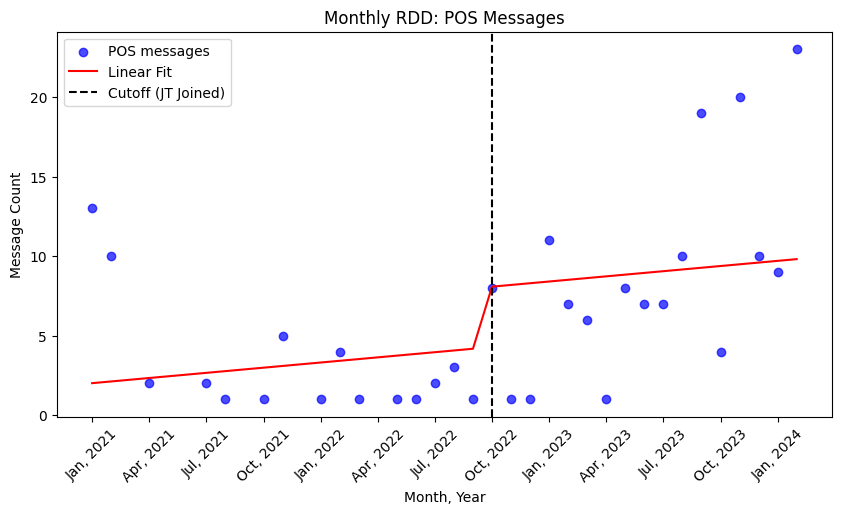

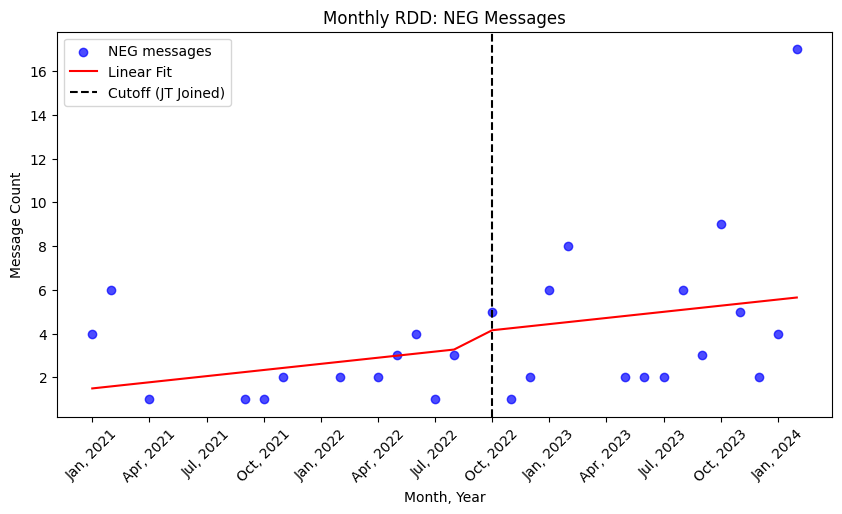

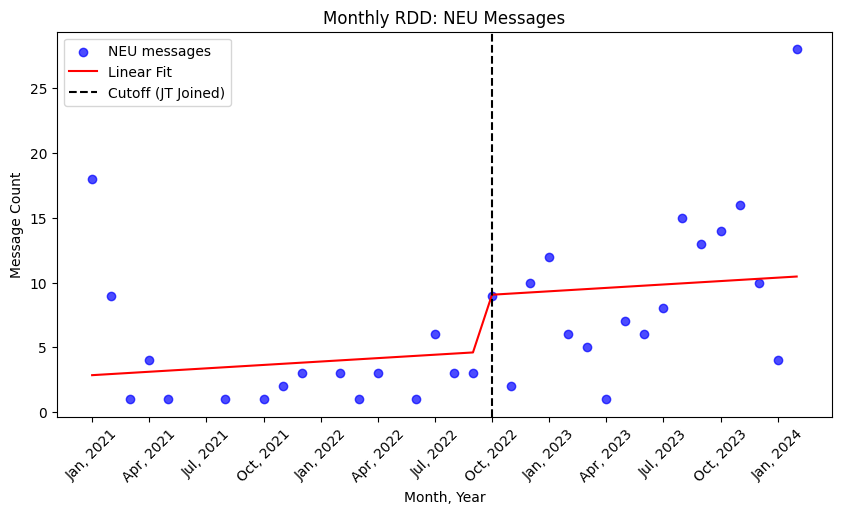

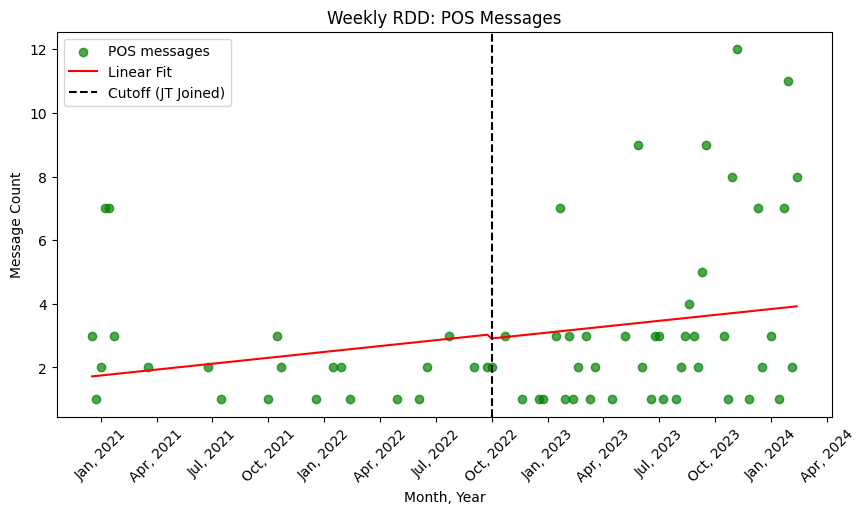

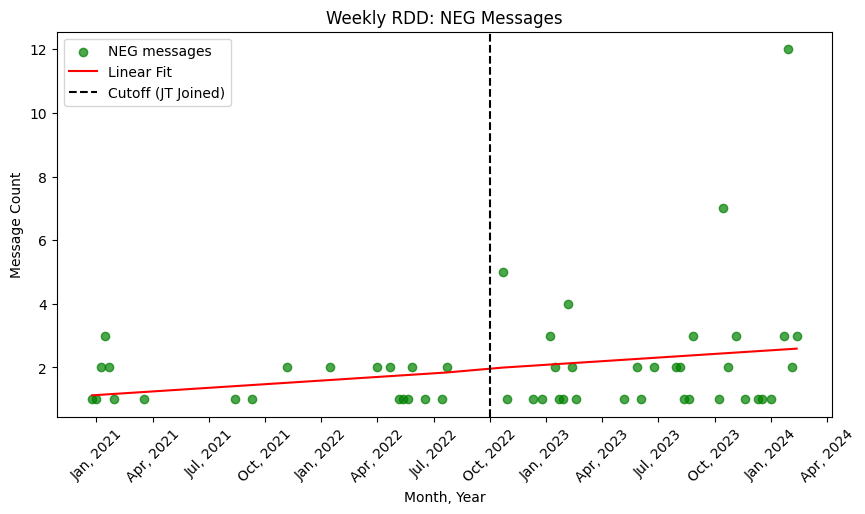

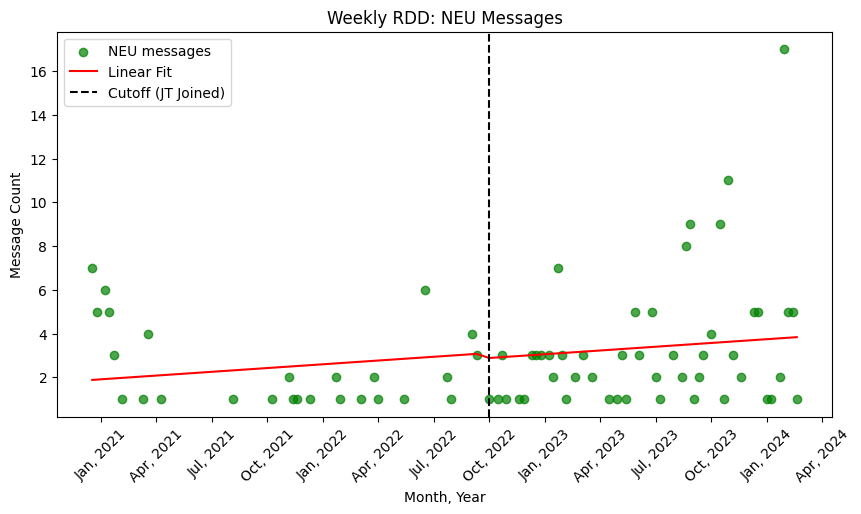

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression

# ---------------------------
# 1. Define key dates for analysis
# ---------------------------
cutoff_date = pd.to_datetime("2022-10-28")      # Jia Tan's join date (cutoff)
treatment_end_date = pd.to_datetime("2024-03-28") # End of treatment period
control_start_date = pd.to_datetime("2021-01-01") # Start of control period

# ---------------------------
# 2. Filter the DataFrame to the analysis period
# ---------------------------
# Ensure the date_parsed column is a datetime type
user_interactions["date_parsed"] = pd.to_datetime(user_interactions["date_parsed"], errors="coerce")
analysis_df = user_interactions[
    (user_interactions["date_parsed"] >= control_start_date) &
    (user_interactions["date_parsed"] <= treatment_end_date)
].copy()

# ---------------------------
# 3. Create Forcing Variables for Monthly and Weekly Analysis
# ---------------------------
# Monthly forcing variable (approx. 30 days per month)
analysis_df["months_since_JT_joined"] = ((analysis_df["date_parsed"] - cutoff_date) / pd.Timedelta(days=30)).astype(int)
# Weekly forcing variable (7 days per week)
analysis_df["weeks_since_JT_joined"] = ((analysis_df["date_parsed"] - cutoff_date) / pd.Timedelta(days=7)).astype(int)

# ---------------------------
# 4. Aggregate Message Counts by Sentiment Category
# ---------------------------
sentiments = ["POS", "NEG", "NEU"]

# Dictionaries to store results
monthly_results = {}  # For each sentiment: (monthly_df, sklearn model)
weekly_results = {}   # For each sentiment: (weekly_df, sklearn model)

for sentiment in sentiments:
    # Filter messages of this sentiment
    df_sent = analysis_df[analysis_df["sentiment"] == sentiment]
    
    # --- Monthly Aggregation ---
    monthly_counts = df_sent.groupby("months_since_JT_joined").size().reset_index(name="message_count")
    monthly_counts["treatment"] = (monthly_counts["months_since_JT_joined"] >= 0).astype(int)
    
    # Prepare data for sklearn
    X_monthly = monthly_counts[["months_since_JT_joined", "treatment"]].values
    y_monthly = monthly_counts["message_count"].values
    
    # Fit linear regression
    lin_model_monthly = LinearRegression()
    lin_model_monthly.fit(X_monthly, y_monthly)
    monthly_counts["predicted"] = lin_model_monthly.predict(X_monthly)
    
    monthly_results[sentiment] = (monthly_counts, lin_model_monthly)
    
    # --- Weekly Aggregation ---
    weekly_counts = df_sent.groupby("weeks_since_JT_joined").size().reset_index(name="message_count")
    weekly_counts["treatment"] = (weekly_counts["weeks_since_JT_joined"] >= 0).astype(int)
    
    X_weekly = weekly_counts[["weeks_since_JT_joined", "treatment"]].values
    y_weekly = weekly_counts["message_count"].values
    
    lin_model_weekly = LinearRegression()
    lin_model_weekly.fit(X_weekly, y_weekly)
    weekly_counts["predicted"] = lin_model_weekly.predict(X_weekly)
    
    weekly_results[sentiment] = (weekly_counts, lin_model_weekly)

# ---------------------------
# 5. Define Custom Formatter Functions for the X-Axis
# ---------------------------
def month_year_formatter(x, pos):
    # x is the offset in months; add it to cutoff_date
    m = int(round(x))
    dt = cutoff_date + pd.DateOffset(months=m)
    return dt.strftime("%b, %Y")  # e.g., "Jan, 2021"

def week_year_formatter(x, pos):
    # x is the offset in weeks; add it to cutoff_date
    w = int(round(x))
    dt = cutoff_date + pd.Timedelta(weeks=w)
    return dt.strftime("%b, %Y")  # e.g., "Jan, 2021"

# ---------------------------
# 6. Plot Monthly RDD Graphs with Sklearn Regression Results
# ---------------------------
for sentiment in sentiments:
    monthly_counts, model_monthly = monthly_results[sentiment]
    
    plt.figure(figsize=(10, 5))
    plt.scatter(monthly_counts["months_since_JT_joined"], monthly_counts["message_count"],
                color="blue", alpha=0.7, label=f"{sentiment} messages")
    plt.plot(monthly_counts["months_since_JT_joined"], monthly_counts["predicted"],
             color="red", label="Linear Fit")
    plt.axvline(x=0, color="black", linestyle="--", label="Cutoff (JT Joined)")
    plt.xlabel("Month, Year")
    plt.ylabel("Message Count")
    plt.title(f"Monthly RDD: {sentiment} Messages")
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Tick every 3 months
    ax.xaxis.set_major_formatter(FuncFormatter(month_year_formatter))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# ---------------------------
# 7. Plot Weekly RDD Graphs with Sklearn Regression Results
# ---------------------------
for sentiment in sentiments:
    weekly_counts, model_weekly = weekly_results[sentiment]
    
    plt.figure(figsize=(10, 5))
    plt.scatter(weekly_counts["weeks_since_JT_joined"], weekly_counts["message_count"],
                color="green", alpha=0.7, label=f"{sentiment} messages")
    plt.plot(weekly_counts["weeks_since_JT_joined"], weekly_counts["predicted"],
             color="red", label="Linear Fit")
    plt.axvline(x=0, color="black", linestyle="--", label="Cutoff (JT Joined)")
    plt.xlabel("Month, Year")
    plt.ylabel("Message Count")
    plt.title(f"Weekly RDD: {sentiment} Messages")
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(13))  # Approximately every 13 weeks (~3 months)
    ax.xaxis.set_major_formatter(FuncFormatter(week_year_formatter))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
